In [31]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
le_df = pd.read_csv("life_expectancy.csv") 
le_df.columns = le_df.columns.str.strip()

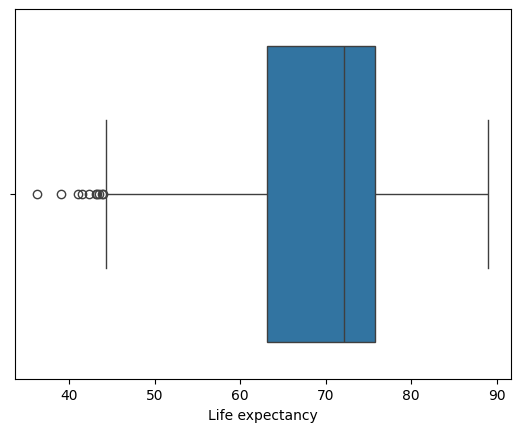

In [8]:
sns.boxplot(x=le_df['Life expectancy'])            # inspecting distribution of target variable using a boxplot
plt.show()

In [43]:
le_df.head()

In [34]:
cols_to_drop = [
    'Country',
    'Year',
    'Adult Mortality',
    'GDP',
    'Income composition of resources',
    'Status',
    'thinness  1-19 years',
    'thinness 5-9 years',
    'HIV/AIDS',
    'Diphtheria',
    'under-five deaths',
    'Polio'
]

le_df = le_df.drop(cols_to_drop, axis=1)

le_df = le_df.dropna() # drops nulls

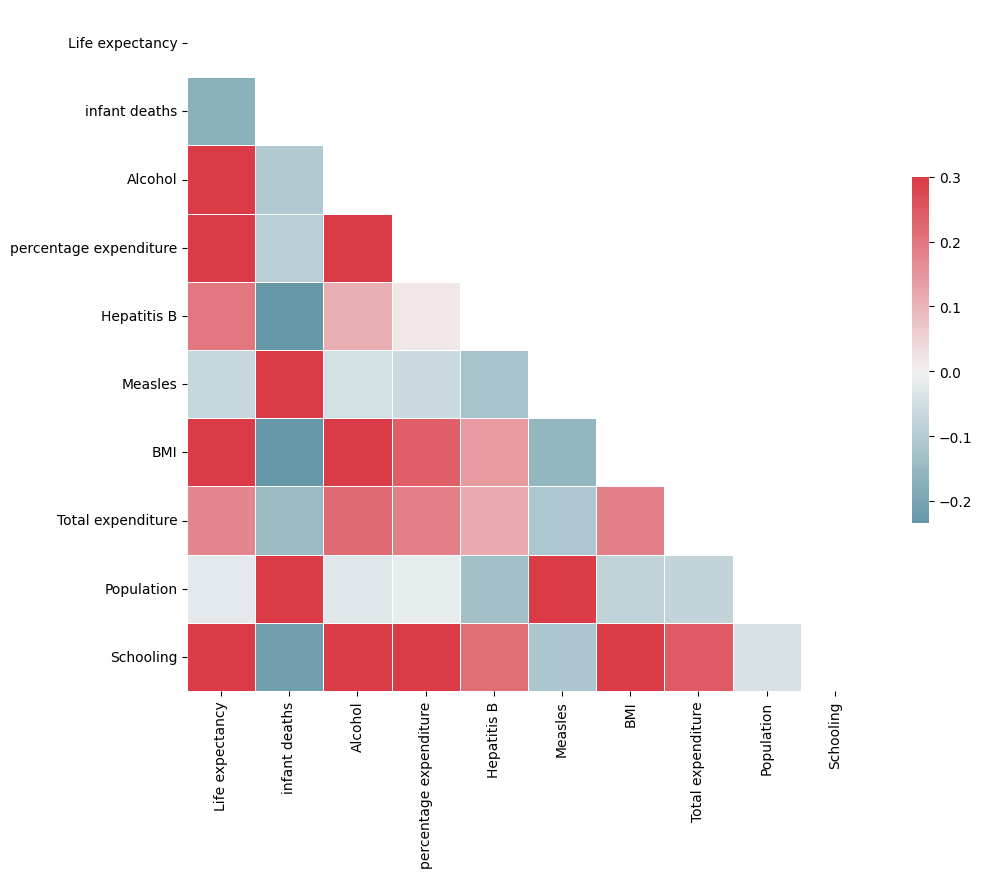

In [35]:
corr_mat = le_df.corr()                               # compute the correlation matrix

mask = np.zeros_like(corr_mat, dtype=bool)            # mask out upper triangle (correlation matrices are symmetric)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)   # generate custom colormap
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

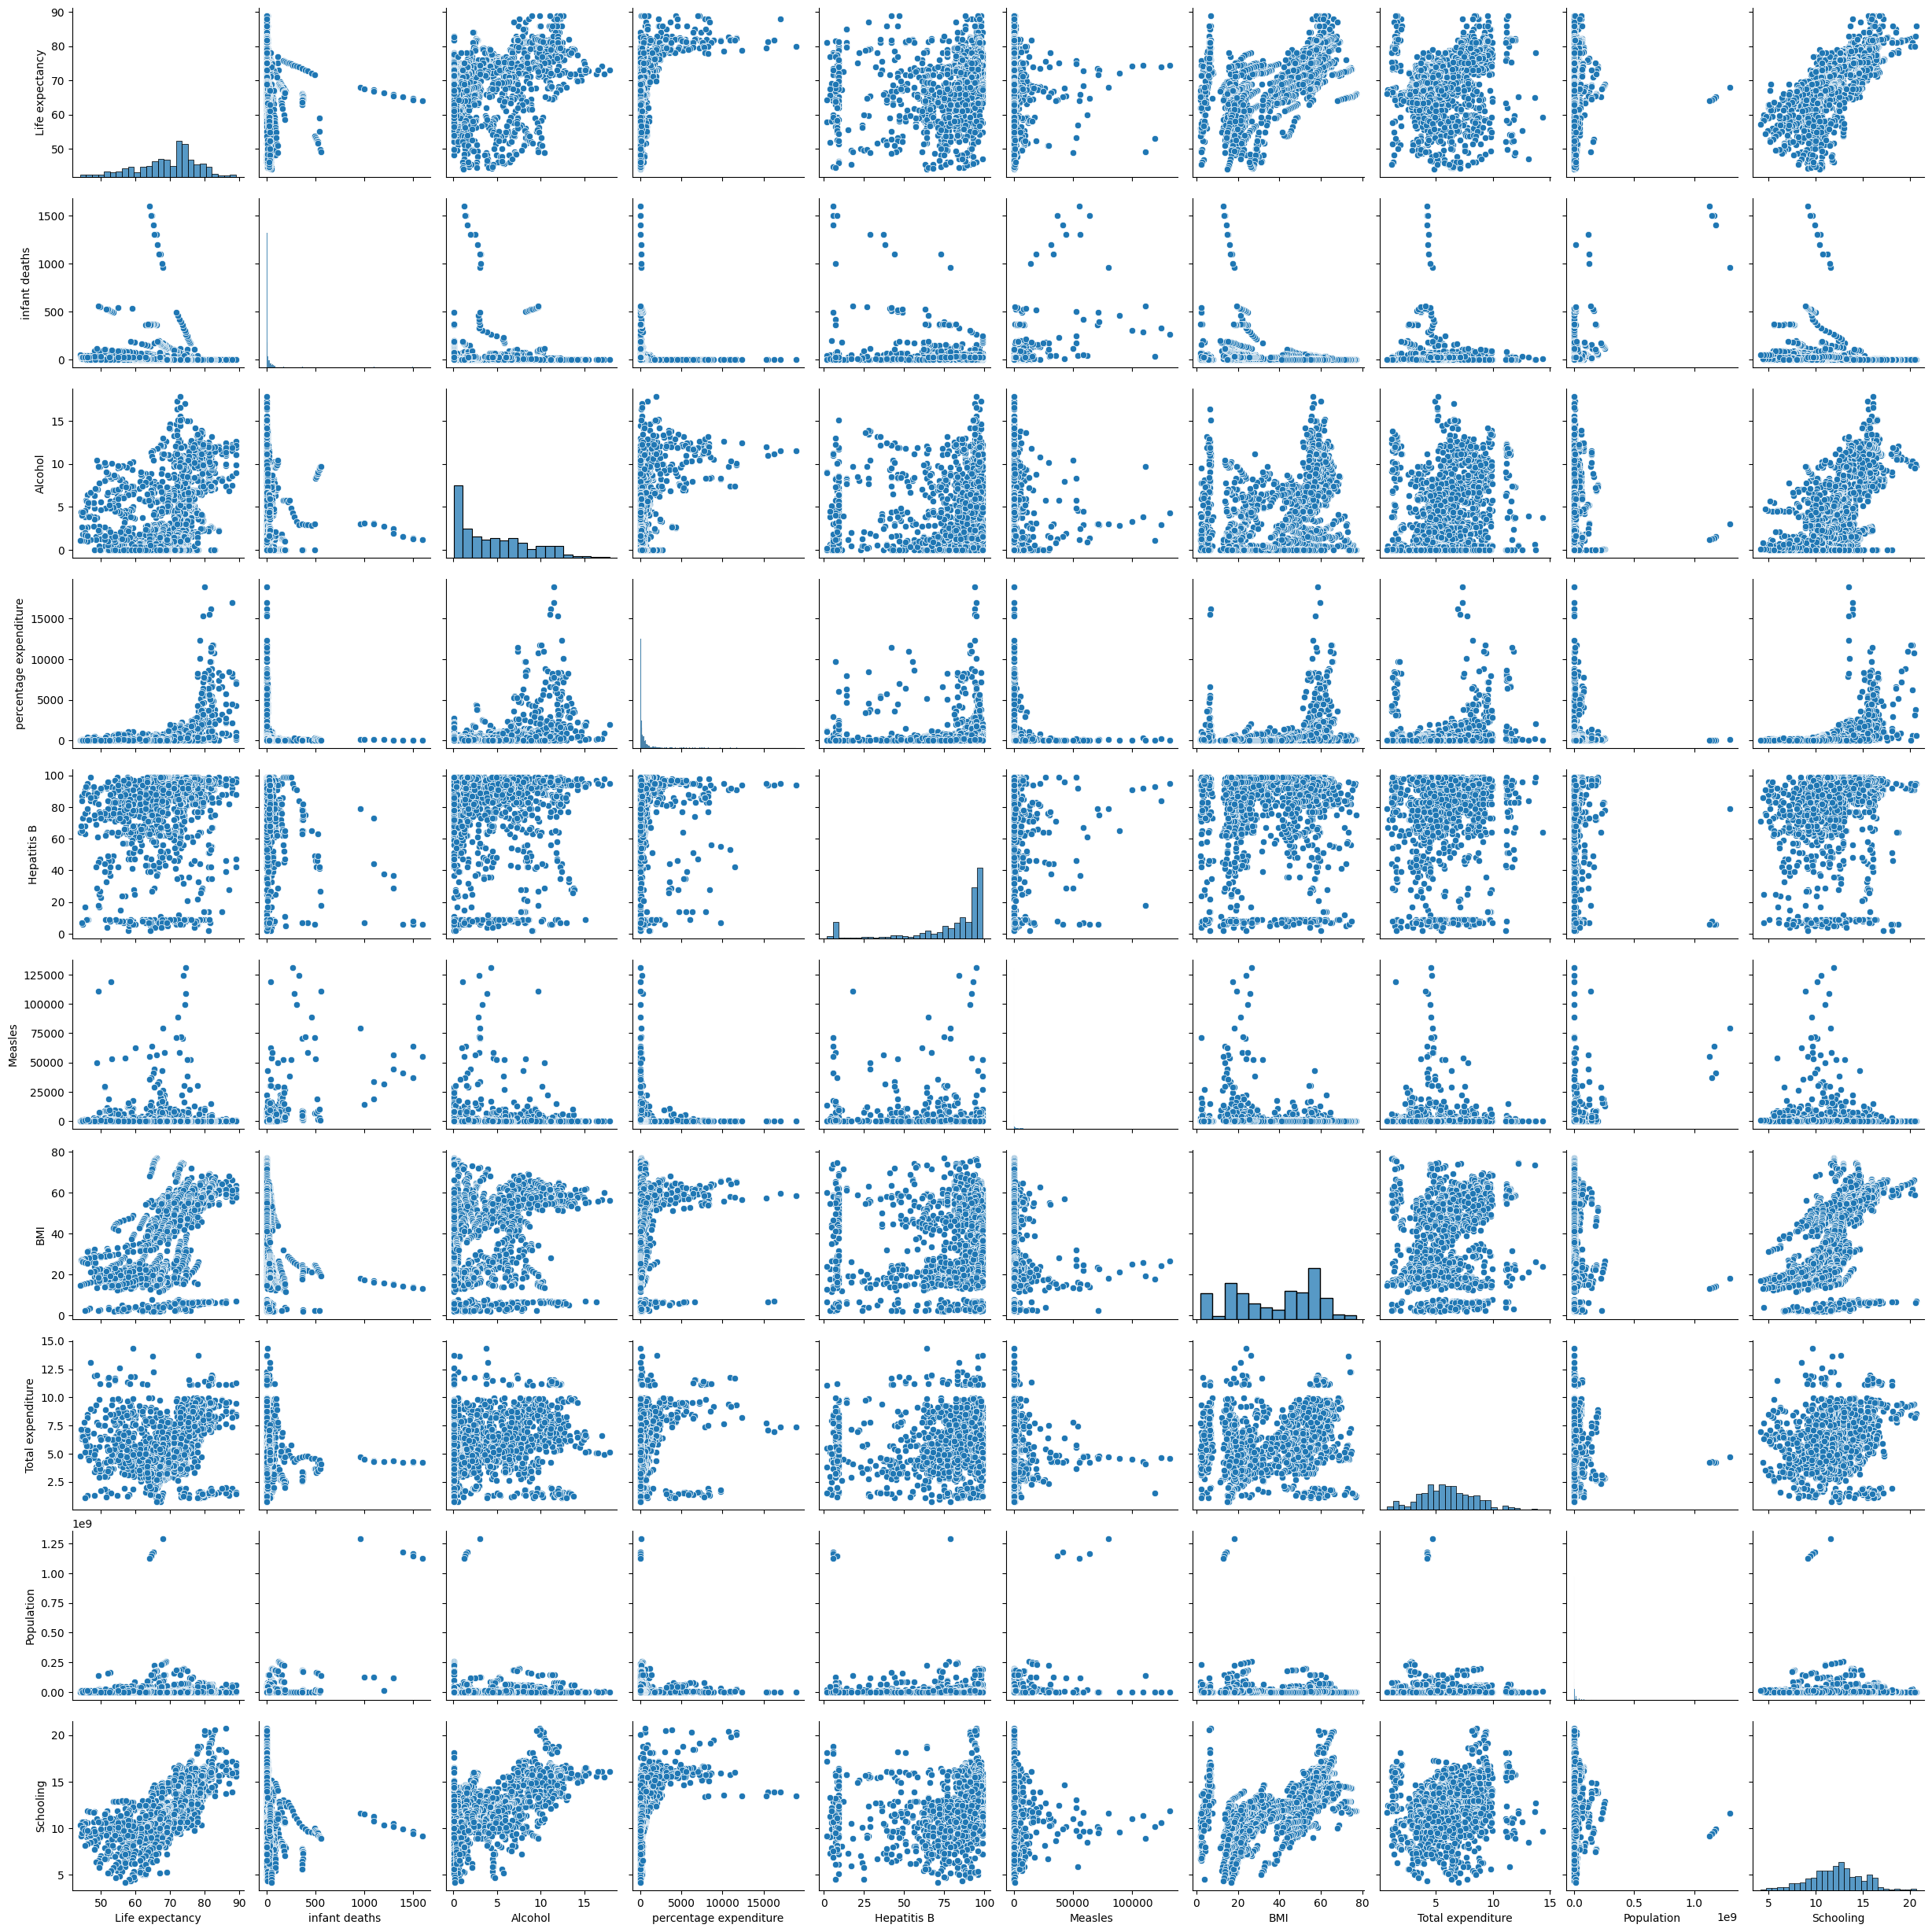

In [36]:
sns.pairplot(le_df)
plt.show()

In [56]:
X = le_df.iloc[:, 1:]
Y = le_df.iloc[:, 0]

In [57]:
X, Y

(      infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles  \
 0                62     0.01               71.279624         65.0     1154   
 1                64     0.01               73.523582         62.0      492   
 2                66     0.01               73.219243         64.0      430   
 3                69     0.01               78.184215         67.0     2787   
 4                71     0.01                7.097109         68.0     3013   
 ...             ...      ...                     ...          ...      ...   
 2933             27     4.36                0.000000         68.0       31   
 2934             26     4.06                0.000000          7.0      998   
 2935             25     4.43                0.000000         73.0      304   
 2936             25     1.72                0.000000         76.0      529   
 2937             24     1.68                0.000000         79.0     1483   
 
        BMI  Total expenditure  Population  School

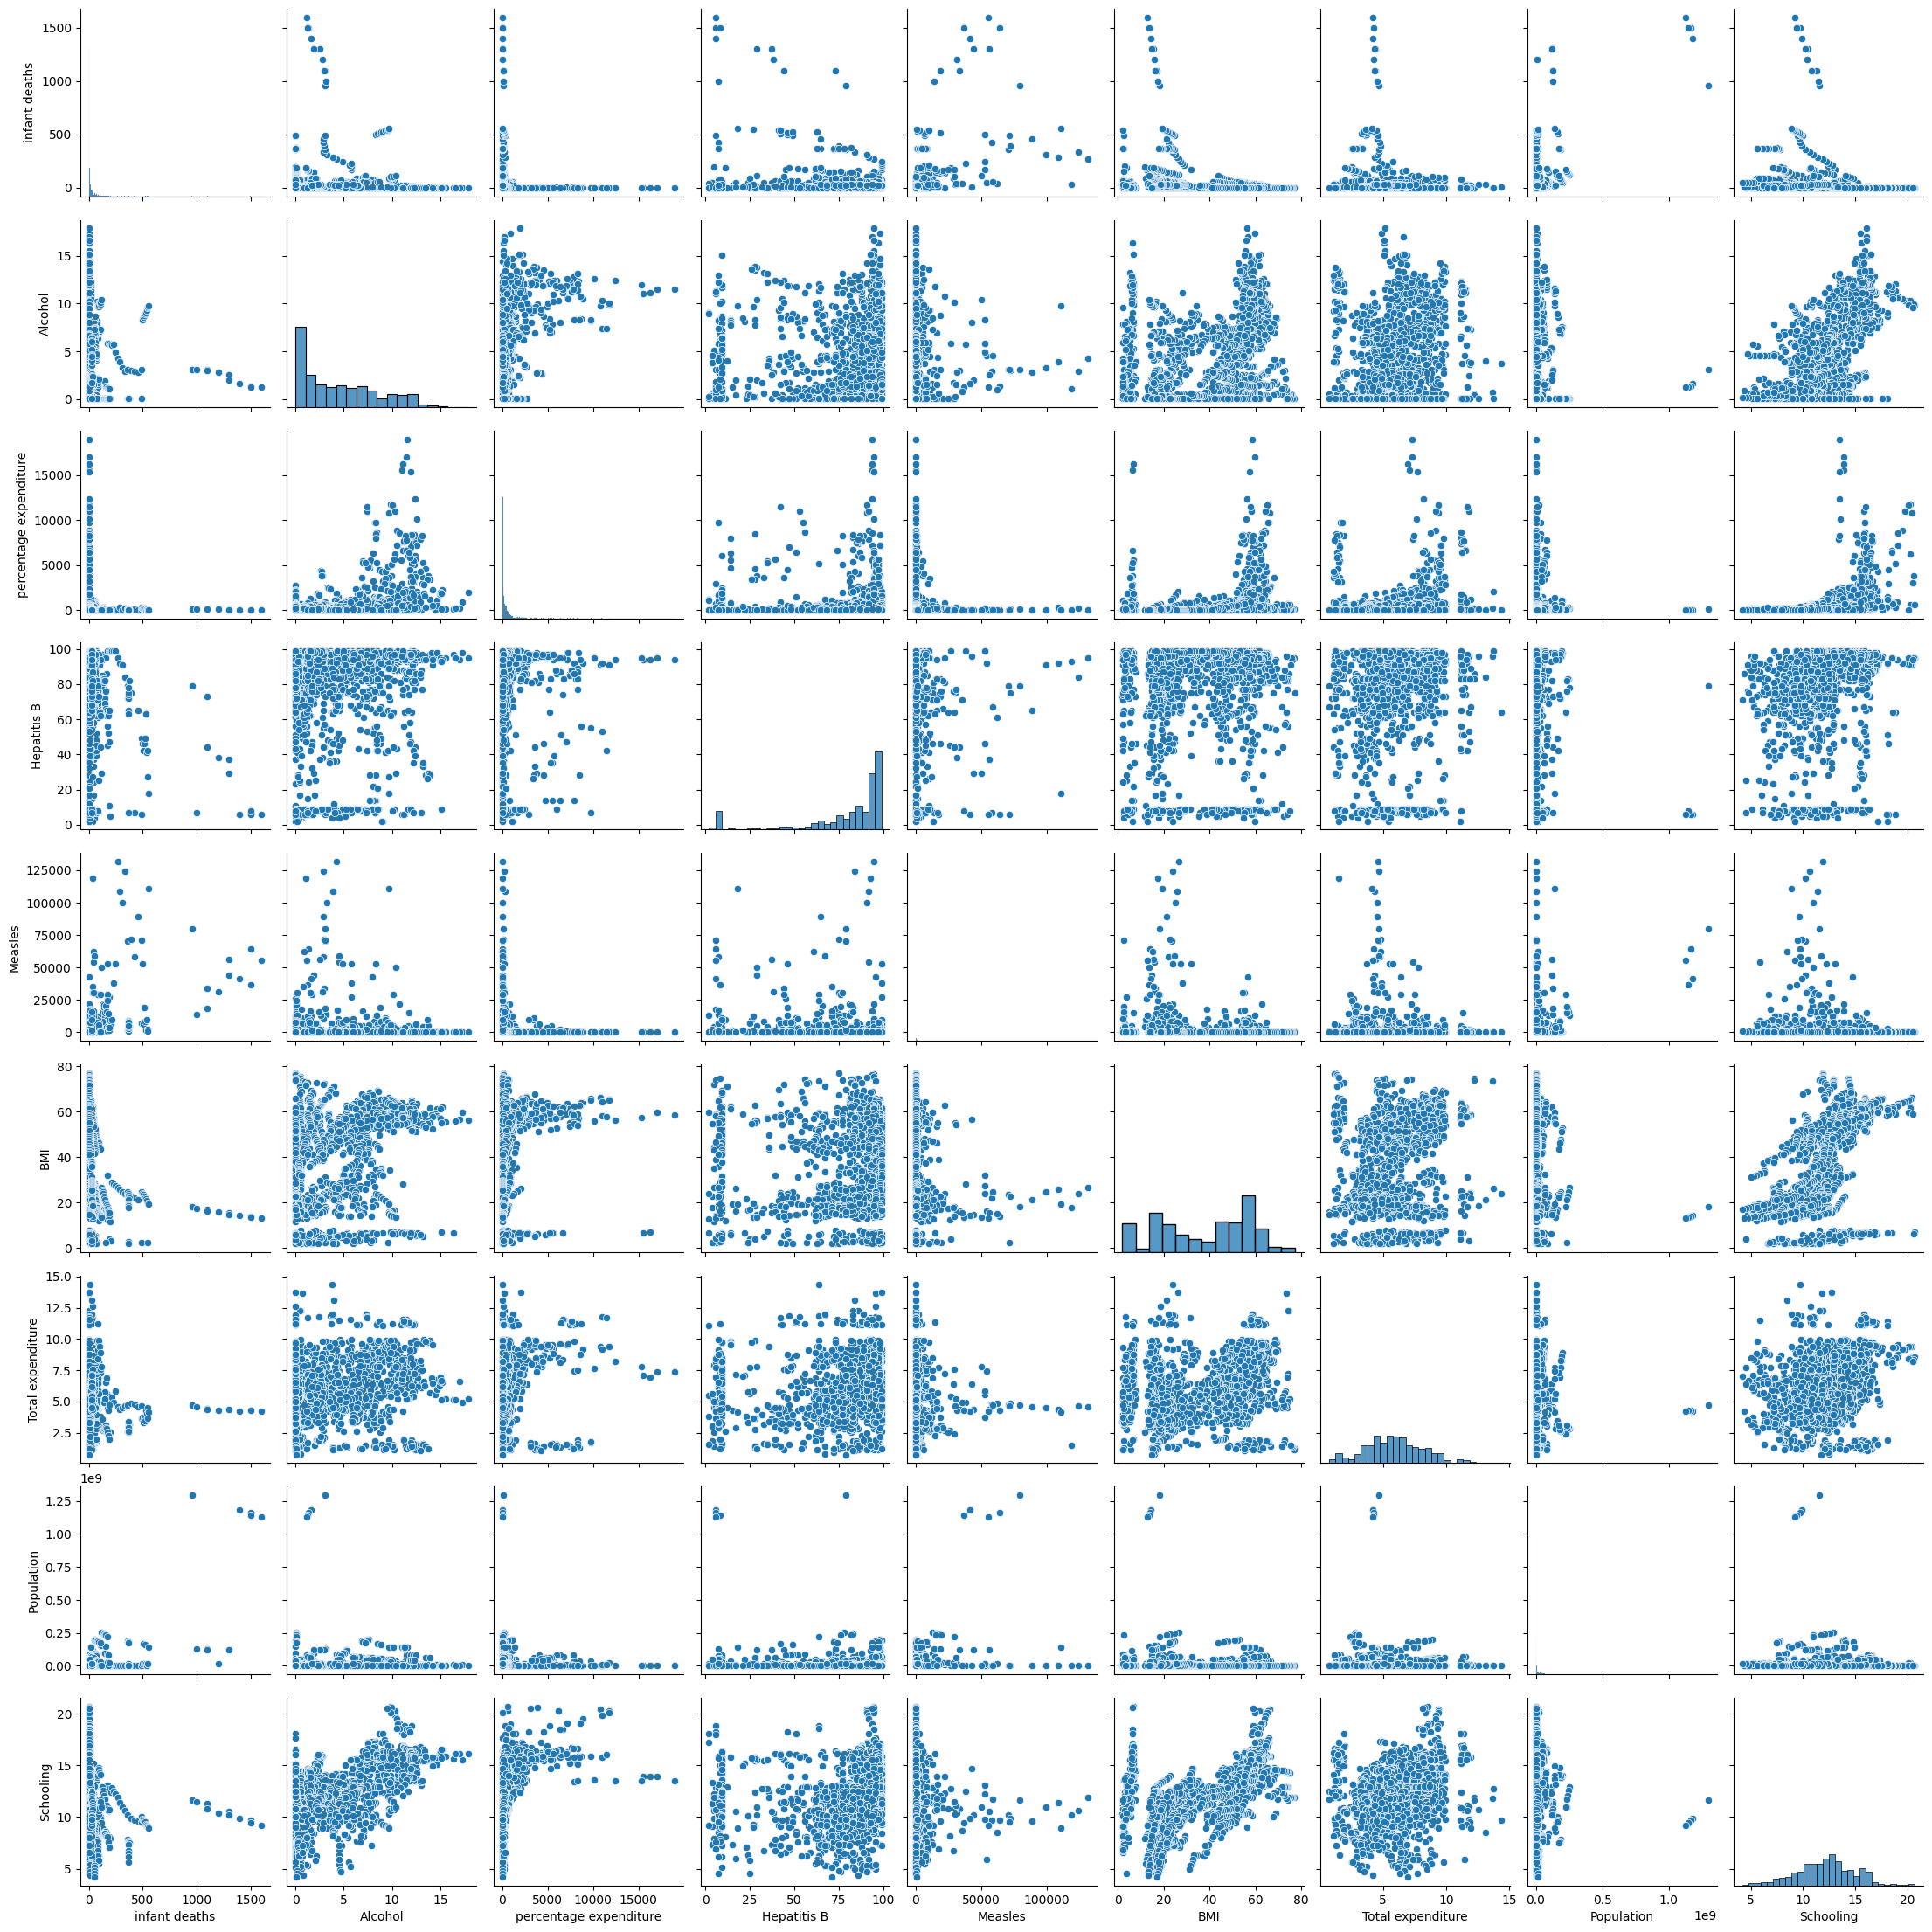

In [58]:
sns.pairplot(X)
plt.show()

In [59]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
scaled_X = scaler.transform(X)

print(f"Feature Means: {scaled_X.mean(axis=0)}")               # all effectively equal to 0
print(f"Feature Variances: {scaled_X.var(axis=0)}")            # all effectively equal to 1

Feature Means: [-1.71525102e-17 -1.02915061e-16  1.11491316e-16 -8.46905192e-17
  0.00000000e+00  2.22982633e-16  2.80872355e-16 -1.28643827e-17
  6.86100409e-16]
Feature Variances: [1. 1. 1. 1. 1. 1. 1. 1. 1.]


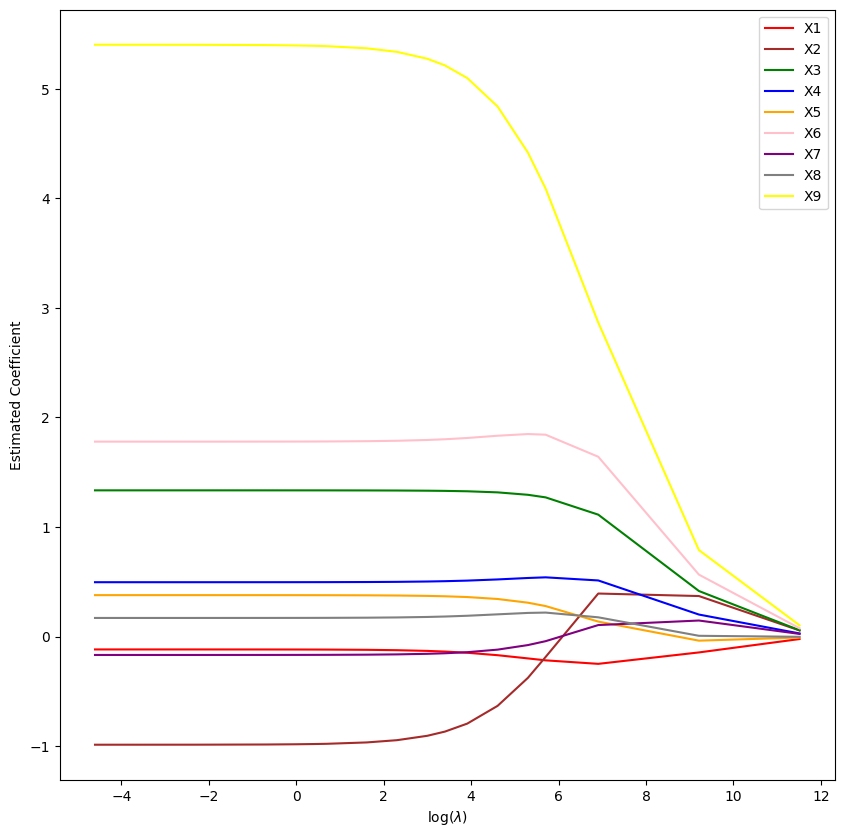

In [72]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

lambdas = [0.01,0.1,0.5,1,1.5, 2,5,10, 20, 30,50, 100, 200, 300,1000,10000, 100000]
N = len(lambdas)
coefs_mat = np.zeros((scaled_X.shape[1], N))
for i in range(N):
    L = lambdas[i]
    ridge_lm = Ridge(alpha=L).fit(scaled_X, Y)
    coefs_mat[:,i] = ridge_lm.coef_

colors = ['red', 'brown', 'green', 'blue', 'orange', 'pink', 'purple', 'grey', 'yellow', 'violet']
plt.figure(figsize=(10,10))
for i in range(X.shape[1]):
    lab = "X" + str(i + 1)
    plt.plot(np.log(lambdas), coefs_mat[i], label=lab, color=colors[i])
    plt.legend()
plt.xlabel(r"log($\lambda$)")
plt.ylabel("Estimated Coefficient")
plt.show()

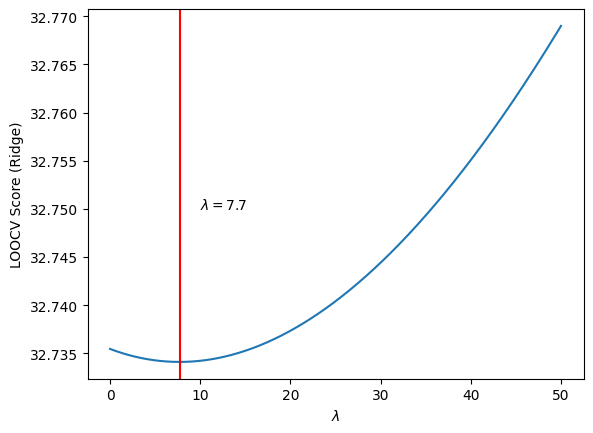

In [207]:
lambdas = np.arange(0, 50.1, step=0.1)
n = scaled_X.shape[0]
N = lambdas.shape[0]
CV_score = np.zeros(N)
curIdx = 0
#Y = Y.to_numpy()
for L in lambdas:
    sq_errs = 0.
    for i in range(n):
        x_i = scaled_X[i]
        x_removed_i = np.delete(scaled_X, i, axis=0)      # dataset without i-th observation (loocv)
        y_i = Y[i]
        y_removed_i = np.delete(Y, i, axis=0)

        mod = Ridge(alpha=L).fit(x_removed_i, y_removed_i)
        sq_errs += ((mod.predict(x_i.reshape(1,-1))-y_i)**2).item()

    CV_score[curIdx] = sq_errs/n
    curIdx += 1

min_idx = np.argmin(CV_score)
plt.plot(lambdas, CV_score)
plt.xlabel(r"$\lambda$")
plt.ylabel("LOOCV Score (Ridge)")
plt.axvline(x=lambdas[min_idx], color="red")
plt.annotate(f"$\\lambda = {lambdas[min_idx]}$", xy=(10,32.750))
plt.show()

In [211]:
rs = np.random.RandomState(123)
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error 

train_prop = 0.7   
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_prop, random_state=rs)

# cv is about choosing the correct alphas, and this selection will be skewed if the data is not normalised.
# furthermore, lasso and ridge are also affected by scaling.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
###########################################


# fit models to train data
m_linearReg = LinearRegression().fit(X_train, y_train)
m_lasso = Lasso(0.0).fit(X_train, y_train)
m_ridge = Ridge(7.7).fit(X_train, y_train)

# compute predictions of each model on the train data
ypred_train_linearReg = m_linearReg.predict(X_train)
ypred_train_lasso = m_lasso.predict(X_train)
ypred_train_ridge = m_ridge.predict(X_train)

# compute predictions of each model on the test data
ypred_test_linearReg = m_linearReg.predict(X_test)
ypred_test_lasso = m_lasso.predict(X_test)
ypred_test_ridge = m_ridge.predict(X_test)

# first compute metrics and store them in array
loss_data = [
    ['linear regression', 
     mean_squared_error(y_train, ypred_train_linearReg), 
     mean_squared_error(y_test, ypred_test_linearReg), 
     mean_absolute_error(y_train, ypred_train_linearReg), 
     mean_absolute_error(y_test, ypred_test_linearReg),
     0,
     r2_score(ypred_train_linearReg, y_train),
     r2_score(ypred_test_linearReg, y_test),
    ],
    ['lasso', 
     mean_squared_error(y_train, ypred_train_lasso), 
     mean_squared_error(y_test, ypred_test_lasso),
     mean_absolute_error(y_train, ypred_train_lasso), 
     mean_absolute_error(y_test, ypred_test_lasso),
     m_lasso.alpha,
     r2_score(ypred_train_lasso, y_train),
     r2_score(ypred_test_lasso, y_test),
    ],
    ['ridge', 
     mean_squared_error(y_train, ypred_train_ridge), 
     mean_squared_error(y_test, ypred_test_ridge),
     mean_absolute_error(y_train, ypred_train_ridge), 
     mean_absolute_error(y_test, ypred_test_ridge),
     m_ridge.alpha,
     r2_score(ypred_train_ridge, y_train),
     r2_score(ypred_test_ridge, y_test),
    ]
]

# create a pandas dataframe and feed it the array and naming the columns
loss_df = pd.DataFrame(loss_data, 
                       columns=['Model', 'train MSE', 'test MSE', 'train MAE', 'test MAE', 'regularisation', 'r2 train', 'r2 test'])


m_lassoCV = LassoCV(alphas=np.logspace(-10, 10, 1000)).fit(X_train, y_train)              
ypred_train_lassoCV = m_lassoCV.predict(X_train)
ypred_test_lassoCV = m_lassoCV.predict(X_test)

# add row to loss_df
lassoCV_row = {'Model': 'lasso CV', 
               'train MSE': mean_squared_error(y_train, ypred_train_lassoCV), 
               'test MSE': mean_squared_error(y_test, ypred_test_lassoCV),
               'train MAE': mean_absolute_error(y_train, ypred_train_lassoCV), 
               'test MAE' :mean_absolute_error(y_test, ypred_test_lassoCV),
               'regularisation': m_lassoCV.alpha_,
               'r2 train': r2_score(ypred_train_lassoCV, y_train),
               'r2 test': r2_score(ypred_test_lassoCV, y_test),
              }

m_ridgeCV = RidgeCV(cv=None,alphas=np.logspace(-20, 20, 1001)).fit(X_train, y_train)                
ypred_train_ridgeCV = m_ridgeCV.predict(X_train)
ypred_test_ridgeCV = m_ridgeCV.predict(X_test)

# add row to loss_df
ridgeCV_row = {'Model': 'ridge CV', 
               'train MSE': mean_squared_error(y_train, ypred_train_ridgeCV), 
               'test MSE': mean_squared_error(y_test, ypred_test_ridgeCV),
               'train MAE': mean_absolute_error(y_train, ypred_train_ridgeCV), 
               'test MAE' :mean_absolute_error(y_test, ypred_test_ridgeCV),
               'regularisation': m_ridgeCV.alpha_,
               'r2 train': r2_score(ypred_train_ridgeCV, y_train),
               'r2 test': r2_score(ypred_test_ridgeCV, y_test),}

pd.concat([loss_df, pd.DataFrame([lassoCV_row]), pd.DataFrame([ridgeCV_row])], ignore_index=True)

,Model,train MSE,test MSE,train MAE,test MAE,regularisation,r2 train,r2 test
0,linear regression,33.336502,30.081001,4.428437,4.140409,0.000000,0.253466,0.291035
1,lasso,33.336502,30.081001,4.428437,4.140409,0.000000,0.253466,0.291035
2,ridge,33.339160,30.105262,4.426888,4.139568,7.700000,0.245652,0.283138
3,lasso CV,33.403707,30.189396,4.426494,4.135041,0.067426,0.227865,0.265868
4,ridge CV,33.340938,30.113315,4.426602,4.139361,10.000000,0.243316,0.280778


In both cases (lasso, ridge) with manual alphas chosen from performing the manual LOOCV from below, we beat the scikit-learn LassoCV and RidgeCV functions.

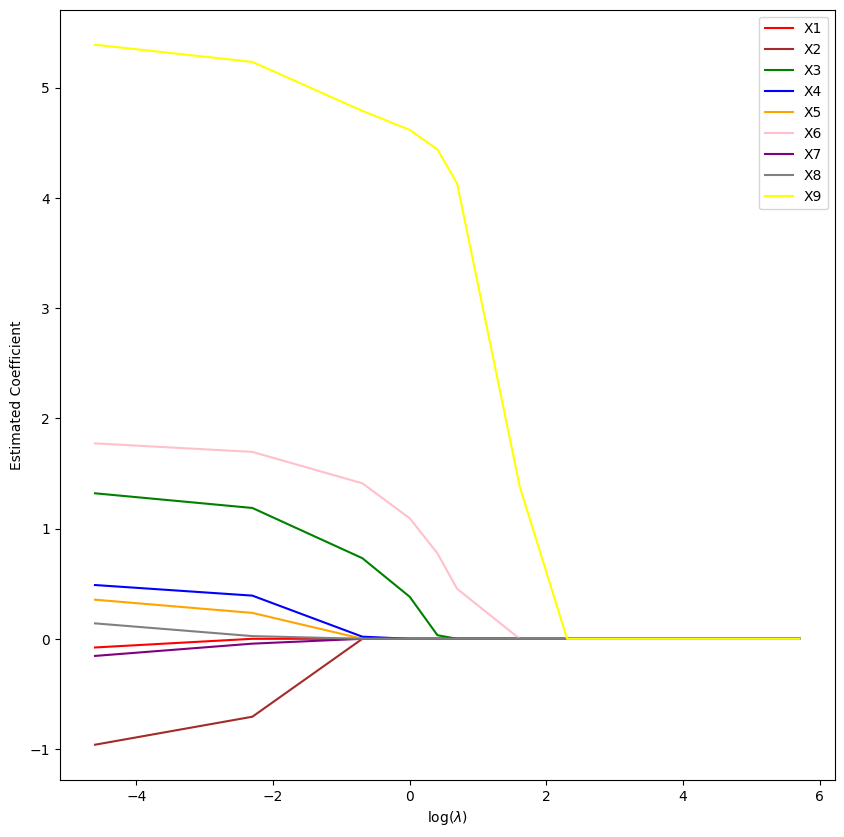

In [162]:
lambdas = [0.01,0.1,0.5,1,1.5, 2,5,10, 20, 30,50, 100, 200, 300]
N = len(lambdas)
coefs_mat = np.zeros((scaled_X.shape[1], N))
for i in range(N):
    L = lambdas[i]
    lasso_lm = Lasso(alpha=L).fit(scaled_X,Y)
    coefs_mat[:,i] = lasso_lm.coef_

colors = ['red', 'brown', 'green', 'blue', 'orange', 'pink', 'purple', 'grey', 'yellow', 'violet']
plt.figure(figsize=(10,10))
for i in range(X.shape[1]):
    lab = "X" + str(i + 1)
    plt.plot(np.log(lambdas), coefs_mat[i], label=lab, color=colors[i])
    plt.legend()
plt.xlabel(r"log($\lambda$)")
plt.ylabel("Estimated Coefficient")
plt.show()

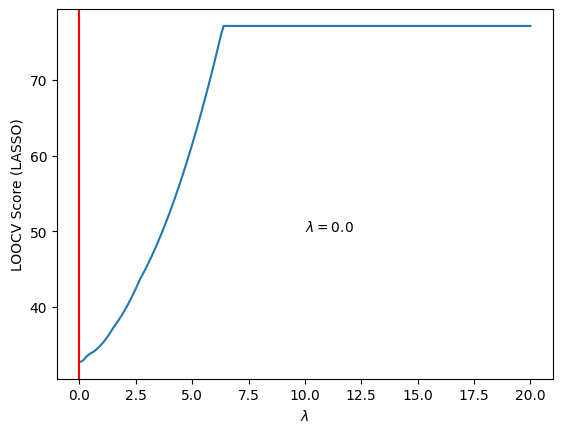

In [166]:
import warnings
warnings.filterwarnings("ignore")

lambdas = np.arange(0, 20.1, step=0.1)
n = scaled_X.shape[0]
N = lambdas.shape[0]
CV_score = np.zeros(N)
curIdx = 0
for L in lambdas:
    sq_errs = 0.
    for i in range(n):
        x_i = scaled_X[i]
        x_removed_i = np.delete(scaled_X, i, axis=0)      # dataset without i-th observation
        y_i = Y[i]
        y_removed_i = np.delete(Y, i, axis=0)

        mod = Lasso(alpha=L).fit(x_removed_i, y_removed_i, )
        sq_errs += ((mod.predict(x_i.reshape(1,-1))-y_i)**2).item()

    CV_score[curIdx] = sq_errs/n
    curIdx += 1

min_idx = np.argmin(CV_score)
plt.plot(lambdas, CV_score)
plt.xlabel(r"$\lambda$")
plt.ylabel("LOOCV Score (LASSO)")
plt.axvline(x=lambdas[min_idx], color="red")
plt.annotate(f"$\\lambda = {lambdas[min_idx]}$", xy=(10,50))
plt.show()